# LGBM Draft (Base Fields Only)

Train/val/test split = 0.6/0.2/0.2, label = next-day TWAP return.

In [366]:
import re
from pathlib import Path
import numpy as np
import pandas as pd

# Optional: set repo root manually
# repo_root = Path('C:/Users/BaiYang/CBOND_DAY')
repo_root = None

root = Path.cwd()
if repo_root is None:
    while root != root.parent and not (root / 'cbond_daily').exists():
        root = root.parent
    if not (root / 'cbond_daily').exists():
        raise FileNotFoundError('Cannot find repo root containing cbond_daily. Set repo_root explicitly.')
else:
    root = repo_root

# Load paths_config.json5 (minimal parsing)
paths_cfg = root / 'cbond_daily' / 'config' / 'paths_config.json5'
text = paths_cfg.read_text(encoding='utf-8')

m = re.search(r'dwd_root\s*:\s*"([^"]+)"', text)
if not m:
    raise ValueError('Cannot parse dwd_root from paths_config.json5')

dwd_root = Path(m.group(1))
print('dwd_root:', dwd_root)


dwd_root: D:\cbond_daily\clean_data


In [367]:
# Settings
import warnings
warnings.filterwarnings('ignore')

start = '2024-01-01'
end = '2026-01-12'

# label uses t+1 prices
buy_twap_col = 'twap_0945_1000'
sell_twap_col = 'twap_1430_1442'

# label/clip settings
Y_COL = 'y'
USE_Y_CLIP = True
Y_CLIP_Q = (0.01, 0.99)  # winsorize by daily quantiles


# grid search settings
USE_GRID_SEARCH = False
GRID_RESULTS_PATH = 'results/grid_search_results.json'
# select best by: 'mse' (min), 'r2' (max), 'acc' (max)
GRID_SELECT_METRIC = 'acc'


# binning settings
BIN_COUNT = 20


# feature enhancement settings
EMA_SPANS = [5, 10, 20]
EMA_COLS = ['close_price', 'amount', 'base_bond_prem_ratio', 'base_ytm']
INTERACTION_PAIRS = [
    ('base_bond_prem_ratio', 'base_ytm'),
    ('base_bond_prem_ratio', 'base_year_to_mat'),
    ('ret_1d', 'base_bond_prem_ratio'),
    ('ovr', 'base_ytm'),
]


# early stopping
EARLY_STOPPING_ROUNDS = 1000

# model params (tunable)
params = {
    'objective': 'regression',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': 12,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.0,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose': -1,
}

# GPU settings (set True if LightGBM GPU build is installed)
use_gpu = True
if use_gpu:
    params.update({
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
    })


In [368]:
# Load cleaned data range
from datetime import datetime

def read_clean_range(root: Path, start_date: str, end_date: str) -> pd.DataFrame:
    frames = []
    for day in pd.date_range(start_date, end_date, freq='D'):
        month = f"{day.year:04d}-{day.month:02d}"
        path = root / month / f"{day.strftime('%Y%m%d')}.parquet"
        if path.exists():
            frames.append(pd.read_parquet(path))
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

raw = read_clean_range(dwd_root, start, end)
print('rows:', len(raw))
raw.head()


rows: 447704


,instrument_code,exchange_code,trade_date,prev_close_price,close_price,amount,code,twap_0930_1000,twap_1430_1500,twap_0945_1000,...,base_year_to_mat,base_ytm,base_duration,base_in_trigger_process,base_conv_value,base_pure_redemption_value,rating_rating,info_instrument_id,info_stock_code,info_instrument_name
0,110003,SZ,2024-01-02,100.0,100.0,0.0,110003.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
1,110004,SZ,2024-01-02,100.0,100.0,0.0,110004.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
2,110005,SZ,2024-01-02,100.0,100.0,0.0,110005.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
3,110006,SZ,2024-01-02,100.0,100.0,0.0,110006.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
4,110007,SZ,2024-01-02,100.0,100.0,0.0,110007.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None


In [369]:
# Build features (base fields only)
base_cols = [
    'close_price', 'prev_close_price', 'amount',
    'base_bond_prem_ratio', 'base_stk_close_price',
    'base_year_to_mat', 'base_ytm',
    'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value'
]

# required columns
req = ['trade_date', 'code'] + base_cols + [buy_twap_col, sell_twap_col]
missing = [c for c in req if c not in raw.columns]
if missing:
    raise KeyError(f'missing columns: {missing}')

work = raw[req].copy()
work['trade_date'] = pd.to_datetime(work['trade_date']).dt.date

# derived features
work['ret_1d'] = work['close_price'] / work['prev_close_price'] - 1.0
work['opt_value'] = work['close_price'] - work['base_pure_redemption_value']
work['ovr'] = work['opt_value'] / work['base_conv_value'].replace(0.0, np.nan)
work['stk_ret_1d'] = work['base_stk_close_price'] / work.groupby('code')['base_stk_close_price'].shift(1) - 1.0

# log features
for col in ['amount', 'base_conv_value', 'base_pure_redemption_value', 'close_price']:
    work[f'log_{col}'] = np.log1p(work[col].clip(lower=0))

# EMA features (by code)
for col in EMA_COLS:
    if col not in work.columns:
        raise KeyError(f'EMA column missing: {col}')
    for span in EMA_SPANS:
        work[f'ema_{col}_{span}'] = work.groupby('code')[col].transform(
            lambda s: s.ewm(span=span, adjust=False).mean()
        )

# interaction features
for a, b in INTERACTION_PAIRS:
    if a not in work.columns or b not in work.columns:
        raise KeyError(f'interaction columns missing: {a}, {b}')
    work[f'{a}_x_{b}'] = work[a] * work[b]

feature_cols = (
    base_cols
    + ['ret_1d', 'opt_value', 'ovr', 'stk_ret_1d']
    + [f'log_{c}' for c in ['amount', 'base_conv_value', 'base_pure_redemption_value', 'close_price']]
    + [f'ema_{c}_{s}' for c in EMA_COLS for s in EMA_SPANS]
    + [f'{a}_x_{b}' for a, b in INTERACTION_PAIRS]
)

# zscore by trade_date (no leakage)
for col in feature_cols:
    work[col] = work.groupby('trade_date')[col].transform(lambda s: (s - s.mean()) / s.std(ddof=0))

work.replace([np.inf, -np.inf], np.nan, inplace=True)

work.head()


,trade_date,code,close_price,prev_close_price,amount,base_bond_prem_ratio,base_stk_close_price,base_year_to_mat,base_ytm,base_in_trigger_process,...,ema_base_bond_prem_ratio_5,ema_base_bond_prem_ratio_10,ema_base_bond_prem_ratio_20,ema_base_ytm_5,ema_base_ytm_10,ema_base_ytm_20,base_bond_prem_ratio_x_base_ytm,base_bond_prem_ratio_x_base_year_to_mat,ret_1d_x_base_bond_prem_ratio,ovr_x_base_ytm
0,2024-01-02,110003.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-02,110004.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-02,110005.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-02,110006.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-02,110007.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [370]:
# Build label y(t+1)
# shift prices by one trading day per code
work['buy_twap_t1'] = work.groupby('code')[buy_twap_col].shift(-1)
work['sell_twap_t1'] = work.groupby('code')[sell_twap_col].shift(-1)
work['y'] = work['sell_twap_t1'] / work['buy_twap_t1'] - 1.0

# clip y by daily quantiles (winsorize)
if USE_Y_CLIP:
    def _clip_by_date(s: pd.Series) -> pd.Series:
        low, high = s.quantile(Y_CLIP_Q[0]), s.quantile(Y_CLIP_Q[1])
        return s.clip(lower=low, upper=high)

    work['y_raw'] = work['y']
    work['y'] = work.groupby('trade_date')['y'].transform(_clip_by_date)

# drop rows with any missing features or label
base_cols = ['trade_date','code'] + feature_cols + ['y']
if 'y_raw' in work.columns:
    base_cols.append('y_raw')
model_df = work[base_cols].dropna()
print('model rows:', len(model_df))
model_df.head()


model rows: 219052


,trade_date,code,close_price,prev_close_price,amount,base_bond_prem_ratio,base_stk_close_price,base_year_to_mat,base_ytm,base_in_trigger_process,...,ema_base_bond_prem_ratio_20,ema_base_ytm_5,ema_base_ytm_10,ema_base_ytm_20,base_bond_prem_ratio_x_base_ytm,base_bond_prem_ratio_x_base_year_to_mat,ret_1d_x_base_bond_prem_ratio,ovr_x_base_ytm,y,y_raw
1179,2024-01-03,110043.SH,0.237097,0.228209,0.513554,-0.706028,-0.703676,-2.420380,0.575391,8.159132,...,-0.711204,0.578118,0.578574,0.578809,0.121336,-1.020245,0.109759,0.172783,0.000211,0.000211
1180,2024-01-03,110044.SH,1.879280,1.870203,0.232510,2.351201,-0.686889,-2.146520,-6.855940,-0.122562,...,2.428724,-6.750950,-6.725669,-6.711003,-9.033817,-0.577571,-0.143403,-6.488501,-0.002681,-0.002681
1181,2024-01-03,110045.SH,0.564687,0.533485,0.507152,-1.036903,-0.563085,-2.117112,-2.121105,-0.122562,...,-1.051180,-1.981534,-1.949784,-1.931647,0.086697,-1.027638,0.108396,-0.190648,0.001436,0.001436
1182,2024-01-03,110047.SH,0.304477,0.300910,-0.067911,-0.332317,-0.862103,-1.876336,0.585584,-0.122562,...,-0.329856,0.570703,0.567222,0.565219,0.169192,-0.856410,0.052092,0.176207,0.000447,0.000447
1183,2024-01-03,110048.SH,1.053787,1.058546,0.707137,-1.042058,-0.512200,-1.846928,-2.774028,-0.122562,...,-1.035191,-2.751813,-2.746112,-2.742751,0.093910,-1.029537,0.111725,-0.552342,0.010304,0.015630


In [371]:
# Time split: 0.6 / 0.2 / 0.2 by date
all_days = sorted(model_df['trade_date'].unique())
if len(all_days) < 10:
    raise ValueError('not enough days for split')

n = len(all_days)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_days = set(all_days[:train_end])
val_days = set(all_days[train_end:val_end])
test_days = set(all_days[val_end:])

train_df = model_df[model_df['trade_date'].isin(train_days)]
val_df = model_df[model_df['trade_date'].isin(val_days)]
test_df = model_df[model_df['trade_date'].isin(test_days)]

print('train/val/test rows:', len(train_df), len(val_df), len(test_df))


train/val/test rows: 140011 42223 36818


In [372]:
import json
# Grid search (coarse) for LGBM params or load best from json
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score

if USE_GRID_SEARCH:
    try:
        import lightgbm as lgb
    except ImportError as exc:
        raise ImportError('lightgbm is not installed. Run: pip install lightgbm') from exc

    X_train = train_df[feature_cols]
    y_train = train_df[Y_COL]
    X_val = val_df[feature_cols]
    y_val = val_df[Y_COL]

    grid = {
        'max_depth': [8, 12, 16],
        'lambda_l1': [0.0, 0.01, 0.1],
        'lambda_l2': [0.0, 0.01, 0.1],
    }

    keys = list(grid.keys())
    combos = list(product(*[grid[k] for k in keys]))
    results = []

    for vals in combos:
        trial_params = dict(params)
        trial_params.update({k: v for k, v in zip(keys, vals)})

        model = lgb.LGBMRegressor(**trial_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='l2',
            callbacks=[lgb.log_evaluation(0)],
        )

        pred = model.predict(X_val)
        mse = float(mean_squared_error(y_val, pred))
        r2 = float(r2_score(y_val, pred))
        acc = float((np.sign(pred) == np.sign(y_val)).mean())

        row = {k: v for k, v in zip(keys, vals)}
        row.update({'mse': mse, 'r2': r2, 'acc': acc})
        results.append(row)

    results_df = pd.DataFrame(results)

    # save grid results
    out_dir = root / 'results'
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / 'grid_search_results.json'
    out_path.write_text(results_df.to_json(orient='records', indent=2), encoding='utf-8')
    print('saved grid results:', out_path)

else:
    results_path = Path(GRID_RESULTS_PATH)
    if not results_path.is_absolute():
        results_path = root / results_path
    if not results_path.exists():
        raise FileNotFoundError(f'grid results not found: {results_path}')
    results_df = pd.DataFrame(json.loads(results_path.read_text(encoding='utf-8')))

metric_cols = {'mse', 'r2', 'acc'}
if not metric_cols.intersection(results_df.columns):
    raise ValueError("grid_search_results.json has no metric columns (mse/r2/acc). Set USE_GRID_SEARCH=True to regenerate.")

# pick best params by selected metric

# metric alias
metric_alias = {
    'l2': 'mse',
    'rmse': 'mse',
}
metric = metric_alias.get(GRID_SELECT_METRIC, GRID_SELECT_METRIC)
keys = ['max_depth', 'lambda_l1', 'lambda_l2']
fallback_metric = 'mse'
if metric not in results_df.columns:
    print(f'metric not found in results: {metric}, fallback to {fallback_metric}')
    metric = fallback_metric

if metric == 'mse':
    best_idx = results_df[metric].idxmin()
else:
    best_idx = results_df[metric].idxmax()

best_params = results_df.loc[best_idx, keys].to_dict()
int_keys = ['max_depth']
for k in int_keys:
    if k in best_params:
        best_params[k] = int(best_params[k])

print(f'best params ({metric}):', best_params)
params.update(best_params)


best params (acc): {'max_depth': 12, 'lambda_l1': 0.1, 'lambda_l2': 0.0}


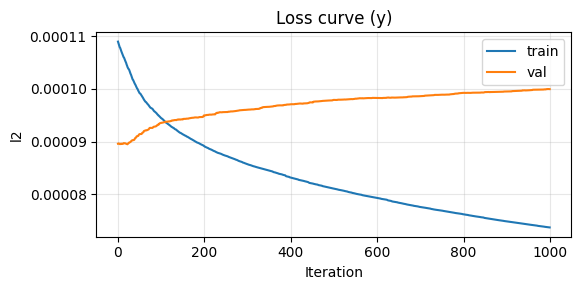

{'best_iteration': 23,
 'val_r2': -0.008095902927059084,
 'val_rmse': 0.009459751444284776,
 'test_r2': -0.013552564790453747,
 'test_rmse': 0.011764340558317272,
 'val_dir_acc': 0.5429505245955996,
 'test_dir_acc': 0.5024444565158347}

In [373]:
# Train LGBM
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

X_train = train_df[feature_cols]
y_train = train_df[Y_COL]
X_val = val_df[feature_cols]
y_val = val_df[Y_COL]
X_test = test_df[feature_cols]
y_test = test_df[Y_COL]

model = lgb.LGBMRegressor(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'val'],
    eval_metric='l2',
    callbacks=[
        lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False),
        lgb.log_evaluation(0),
    ],
)

best_iter = model.best_iteration_ if model.best_iteration_ is not None else model.n_estimators

# Loss curve (train/val)
evals = model.evals_result_
train_key = 'train' if 'train' in evals else ('training' if 'training' in evals else None)
val_key = 'val' if 'val' in evals else ('valid_0' if 'valid_0' in evals else ('valid_1' if 'valid_1' in evals else None))
if train_key and val_key:
    metric = next(iter(evals[train_key].keys()))
    plt.figure(figsize=(6, 3))
    plt.plot(evals[train_key][metric], label=train_key)
    plt.plot(evals[val_key][metric], label=val_key)
    plt.title(f'Loss curve ({Y_COL})')
    plt.xlabel('Iteration')
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

pred_val = model.predict(X_val, num_iteration=best_iter)
pred_test = model.predict(X_test, num_iteration=best_iter)

# direction accuracy (sign match)
val_dir_acc = float((np.sign(pred_val) == np.sign(y_val)).mean())
test_dir_acc = float((np.sign(pred_test) == np.sign(y_test)).mean())

metrics = {
    'best_iteration': int(best_iter),
    'val_r2': r2_score(y_val, pred_val),
    'val_rmse': mean_squared_error(y_val, pred_val) ** 0.5,
    'test_r2': r2_score(y_test, pred_test),
    'test_rmse': mean_squared_error(y_test, pred_test) ** 0.5,
    'val_dir_acc': val_dir_acc,
    'test_dir_acc': test_dir_acc,
}
metrics


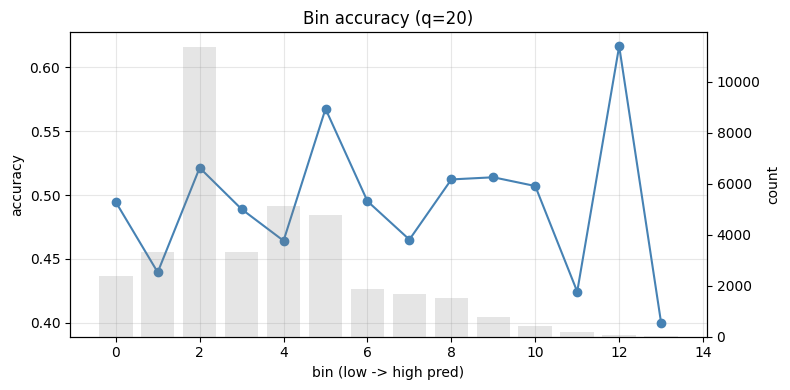

In [374]:
# Bin analysis by prediction (accuracy per bin, on test set)
import matplotlib.pyplot as plt

# use test set
pred_test = model.predict(X_test)
df_bins = test_df[['trade_date', 'code']].copy()
df_bins['y'] = y_test
df_bins['pred'] = pred_test
df_bins['sign_hit'] = (np.sign(df_bins['pred']) == np.sign(df_bins['y'])).astype(int)

# per-day qcut bins
def _assign_bins(day_df):
    if len(day_df) < BIN_COUNT:
        return None
    bins = pd.qcut(day_df['pred'], q=BIN_COUNT, labels=False, duplicates='drop')
    if bins is None or bins.isna().all():
        return None
    day_df = day_df.copy()
    day_df['bin'] = bins
    return day_df

parts = []
for d, g in df_bins.groupby('trade_date'):
    out = _assign_bins(g)
    if out is not None and 'bin' in out.columns:
        parts.append(out)

if not parts:
    print('no valid days for binning')
else:
    df_bins = pd.concat(parts, ignore_index=True)
    # weighted accuracy per bin (by sample count)
    grouped = df_bins.groupby('bin').agg(
        acc=('sign_hit', 'mean'),
        count=('sign_hit', 'size'),
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(grouped['bin'], grouped['acc'], marker='o', color='steelblue')
    ax1.set_xlabel('bin (low -> high pred)')
    ax1.set_ylabel('accuracy')
    ax1.set_title(f'Bin accuracy (q={BIN_COUNT})')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.bar(grouped['bin'], grouped['count'], alpha=0.2, color='gray')
    ax2.set_ylabel('count')
    plt.tight_layout()
    plt.show()


In [375]:
# Feature importance (top 20)
import pandas as pd

imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
imp.head(20)


base_in_trigger_process            433
ovr_x_base_ytm                      54
log_amount                          32
ema_base_ytm_5                      31
amount                              26
base_ytm                            14
ovr                                 14
ret_1d_x_base_bond_prem_ratio       12
opt_value                           10
close_price                          9
ret_1d                               8
ema_base_ytm_10                      7
base_bond_prem_ratio                 7
ema_base_bond_prem_ratio_5           4
ema_amount_5                         4
ema_amount_10                        3
log_close_price                      3
base_conv_value                      3
base_bond_prem_ratio_x_base_ytm      3
ema_base_ytm_20                      2
dtype: int32